#### Mt. SAC CISB 62 Midterm Project Fall 2023

#### Student Name: Aron Joo

This project will work with the CIFAR10 small images classification dataset(https://keras.io/api/datasets/cifar10/)
This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories; and I will perform Deep Learning techniques on it. There are over 10 classes in the dataset and I will use CNN to identify which classes the images would belong to. I will visualize loss, accuracy, predict results, tune hyperparameters, and show a confusion matrix.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

#import warnings and ignore them
import warnings
warnings.filterwarnings('ignore')

import keras
from sklearn.model_selection import GridSearchCV
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K  
from keras import datasets, layers, models
from keras import regularizers

from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import os

from keras_tuner.tuners import RandomSearch
from keras.layers import Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools


#from keras.utils import np_utils
from keras.utils import to_categorical
import datetime


Using TensorFlow backend


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


#### We need a SSL connection to download the dataset

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### CIFAR10 Dataset

In [5]:
# setting class names
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#loading the dataset
from tensorflow.keras.datasets import cifar10 
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
#Loads the CIFAR10 dataset
data = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 8s 0us/step


#### Let's see the shape

In [6]:
# Checking the number of rows (records) and columns (features)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Visualize several images

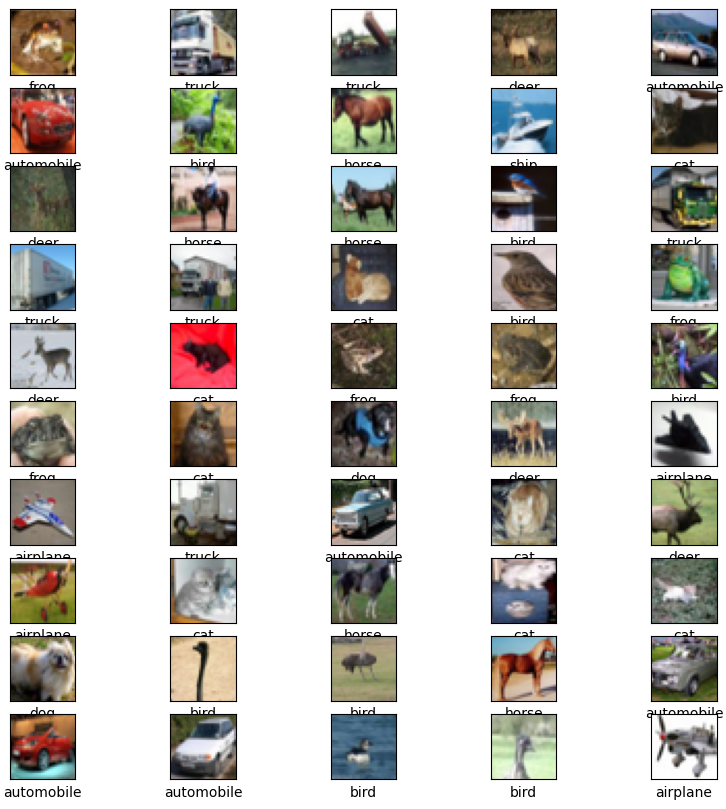

In [18]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


#### Select a sample image


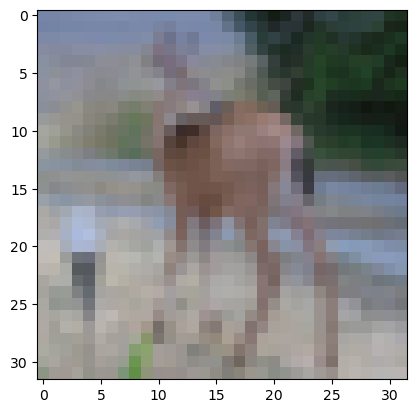

In [20]:
sample = plt.imshow(x_test[100])


#### Plot an image


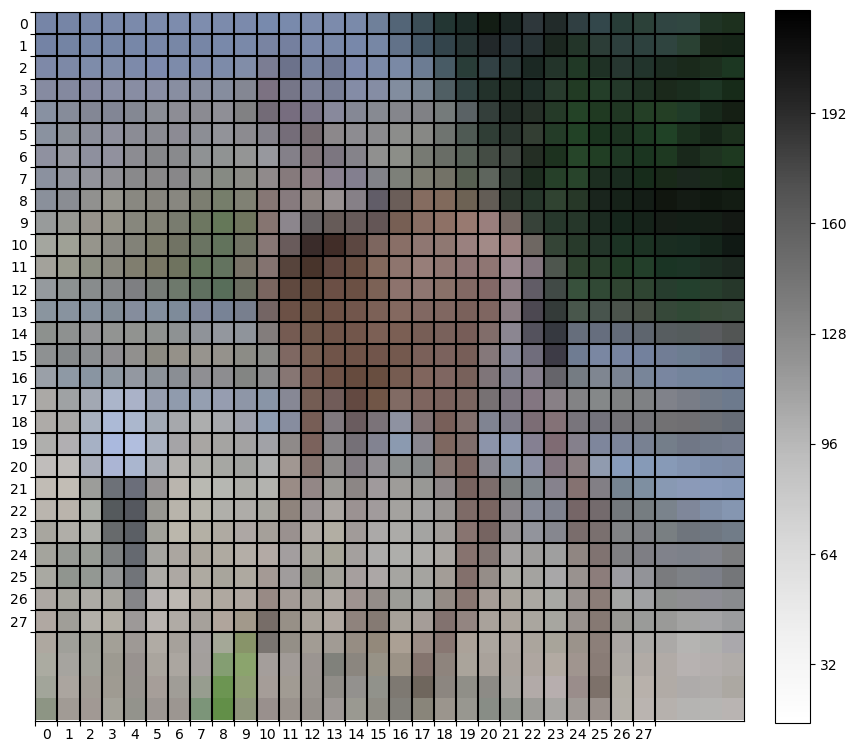

In [24]:
plt.figure(figsize = (10,10))
img = x_test[100]
plt.imshow(img,cmap="Greys")
ax = plt.gca()

# First turn off the  major labels, but not the major ticks
plt.tick_params(
    axis='both',        # changes apply to the both x and y axes
    which='major',      # Change the major ticks only
    bottom=True,        # ticks along the bottom edge are on
    left=True,          # ticks along the top edge are on
    labelbottom=False,  # labels along the bottom edge are off
    labelleft=False)    # labels along the left edge are off

# Next turn off the minor ticks, but not the minor labels
plt.tick_params(
    axis='both',        # changes apply to both x and y axes
    which='minor',      # Change the minor ticks only
    bottom=False,       # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=True,   # labels along the bottom edge are on
    labelleft=True)     # labels along the left edge are on

# Set the major ticks, starting at 1 (the -0.5 tick gets hidden off the canvas)
ax.set_xticks(np.arange(-.5, 28, 1))
ax.set_yticks(np.arange(-.5, 28, 1))

# Set the minor ticks and labels
ax.set_xticks(np.arange(0, 28, 1), minor=True);
ax.set_xticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);
ax.set_yticks(np.arange(0, 28, 1), minor=True);
ax.set_yticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);

ax.grid(color='black', linestyle='-', linewidth=1.5)
_ = plt.colorbar(fraction=0.046, pad=0.04, ticks=[0,32,64,96,128,160,192,224,255])


#### Check the number of unique classes 

In [31]:
print(np.unique(y_train))
print(np.unique(y_test))


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


#### Data Preprocessing

In [37]:
# Converting the pixels data to float type(one hot encoding) since it needs to be float by default
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# Standardizing (255 is the total number of pixels an image can have)
x_train = x_train / 255
x_test = x_test / 255 

# One hot encoding the target class (labels)
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


#### Building a Convolutional Neural Network

In [38]:
# Creating a sequential model and adding layers to it

model = Sequential()

# first Convolutional layer
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())

# second layer
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

# third layer
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())

# fourth
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# fifth
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())

# sixth
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

# Adding a dense layer (fully connected)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#### Checking the model summary

In [39]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

#### Compiling the Model

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


#### Training the Model

In [41]:
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])


Epoch 1/10
782/782 [==============================] - 101s 125ms/step - loss: 1.7406 - accuracy: 0.3992 - val_loss: 1.3001 - val_accuracy: 0.5298
Epoch 2/10
782/782 [==============================] - 98s 125ms/step - loss: 1.2165 - accuracy: 0.5634 - val_loss: 1.1015 - val_accuracy: 0.6140
Epoch 3/10
782/782 [==============================] - 97s 124ms/step - loss: 1.0204 - accuracy: 0.6392 - val_loss: 0.8128 - val_accuracy: 0.7132
Epoch 4/10
782/782 [==============================] - 98s 125ms/step - loss: 0.9018 - accuracy: 0.6846 - val_loss: 0.8971 - val_accuracy: 0.6854
Epoch 5/10
782/782 [==============================] - 101s 129ms/step - loss: 0.8226 - accuracy: 0.7127 - val_loss: 0.7089 - val_accuracy: 0.7487
Epoch 6/10
782/782 [==============================] - 99s 126ms/step - loss: 0.7657 - accuracy: 0.7353 - val_loss: 0.6745 - val_accuracy: 0.7676
Epoch 7/10
782/782 [==============================] - 97s 124ms/step - loss: 0.7181 - accuracy: 0.7518 - val_loss: 0.6731 - val_

#### Visualizing the Evaluation

Text(0.5, 1.0, 'Model Loss')

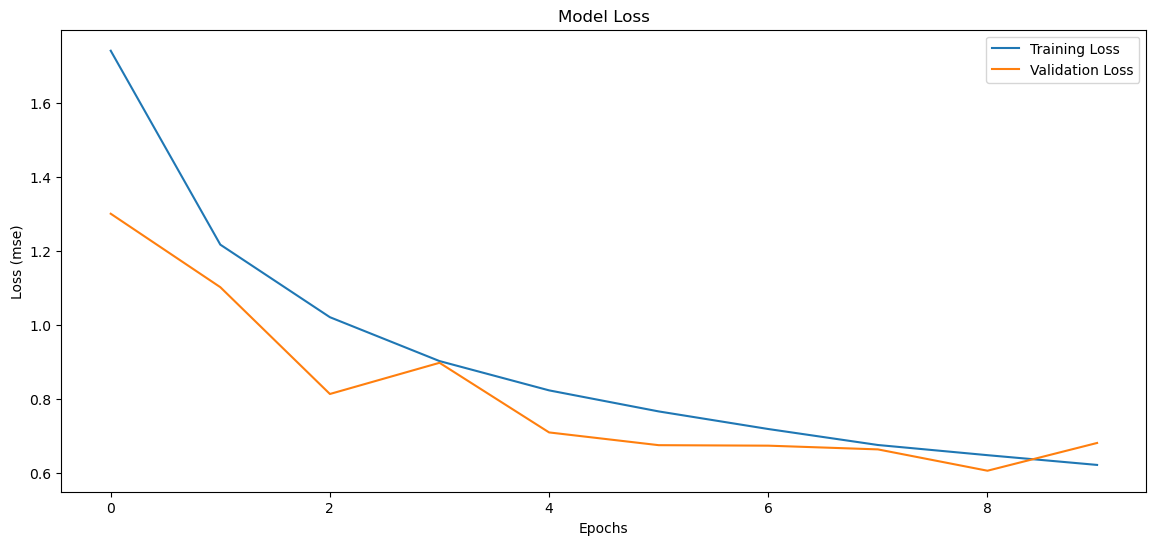

In [42]:
# Loss curve
plt.figure(figsize=[14,6])
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss (mse)', fontsize=10)
plt.title('Model Loss', fontsize=12)


#### Print the accuracy curve

Text(0.5, 1.0, 'Accuracy Curves')

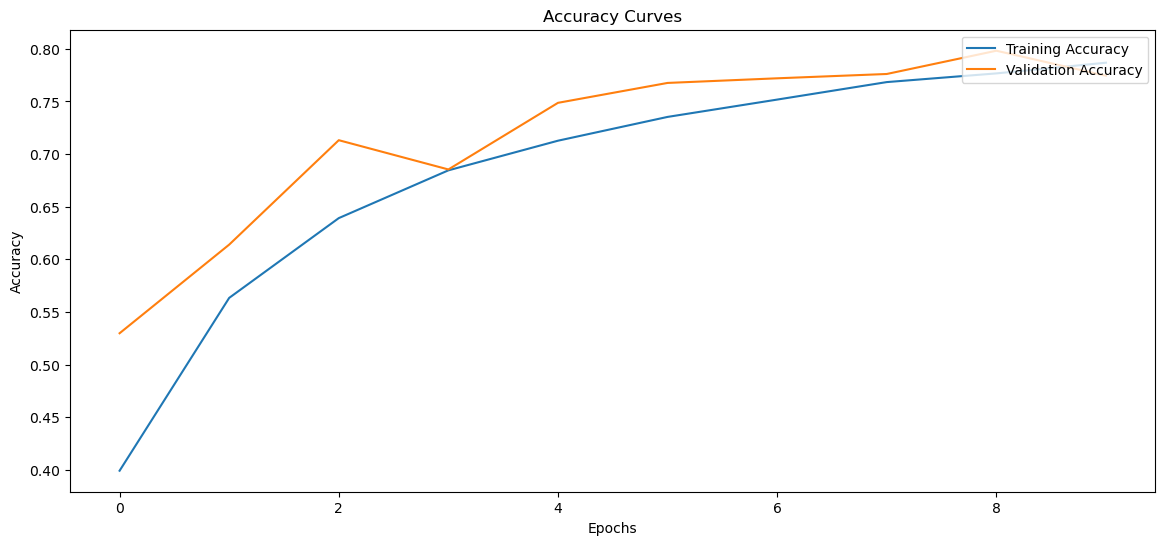

In [43]:
# Accuracy curve
plt.figure(figsize=[14,6])
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)


#### Save the Model

In [44]:
from keras.models import load_model 
model.save('cifar10_model.h5')


#### Loading the Saved Model

In [45]:
#loading the saved model 
from keras.models import load_model 
model = load_model('cifar10_model.h5')


### Evaluate the model (loss and accuracy)

In [46]:
loss, accuracy = model.evaluate(x_test, y_test)


313/313 [==============================] - 6s 18ms/step - loss: 0.6804 - accuracy: 0.7744


#### Predicting the Result

In [47]:
# Making the Predictions
pred = model.predict(x_test)
print(pred)

# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)


313/313 [==============================] - 5s 16ms/step
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.94 0.   ... 0.   0.06 0.  ]
 [0.   0.15 0.   ... 0.   0.82 0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.01 0.98 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 1.   0.   0.  ]]
[3 1 8 ... 5 1 7]


In [48]:
from sklearn.metrics import mean_absolute_error 


In [49]:
#display the prediction of first 5 values, then calculate mae, lastly print first 5 predictions
# Let's check how much we are off on average 
# Enter three lines of code here:
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
y_pred[0:5]


313/313 [==============================] - 5s 16ms/step


array([[0.  , 0.  , 0.  , 0.6 , 0.  , 0.39, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.94, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  ],
       [0.  , 0.15, 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.82, 0.  ],
       [0.14, 0.09, 0.31, 0.03, 0.01, 0.  , 0.01, 0.  , 0.39, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.98, 0.  , 0.  , 0.  ]], dtype=float32)

In [50]:
#print mae value
mae


0.059213113

In [51]:
#print the real value of record 20
y_pred[20]


array([0.  , 0.01, 0.  , 0.01, 0.01, 0.03, 0.  , 0.92, 0.  , 0.01], dtype=float32)

#### Let's take 25 images from the testing data and see how many of it we predicted correctly.

#### Plotting the Actual vs. Predicted results

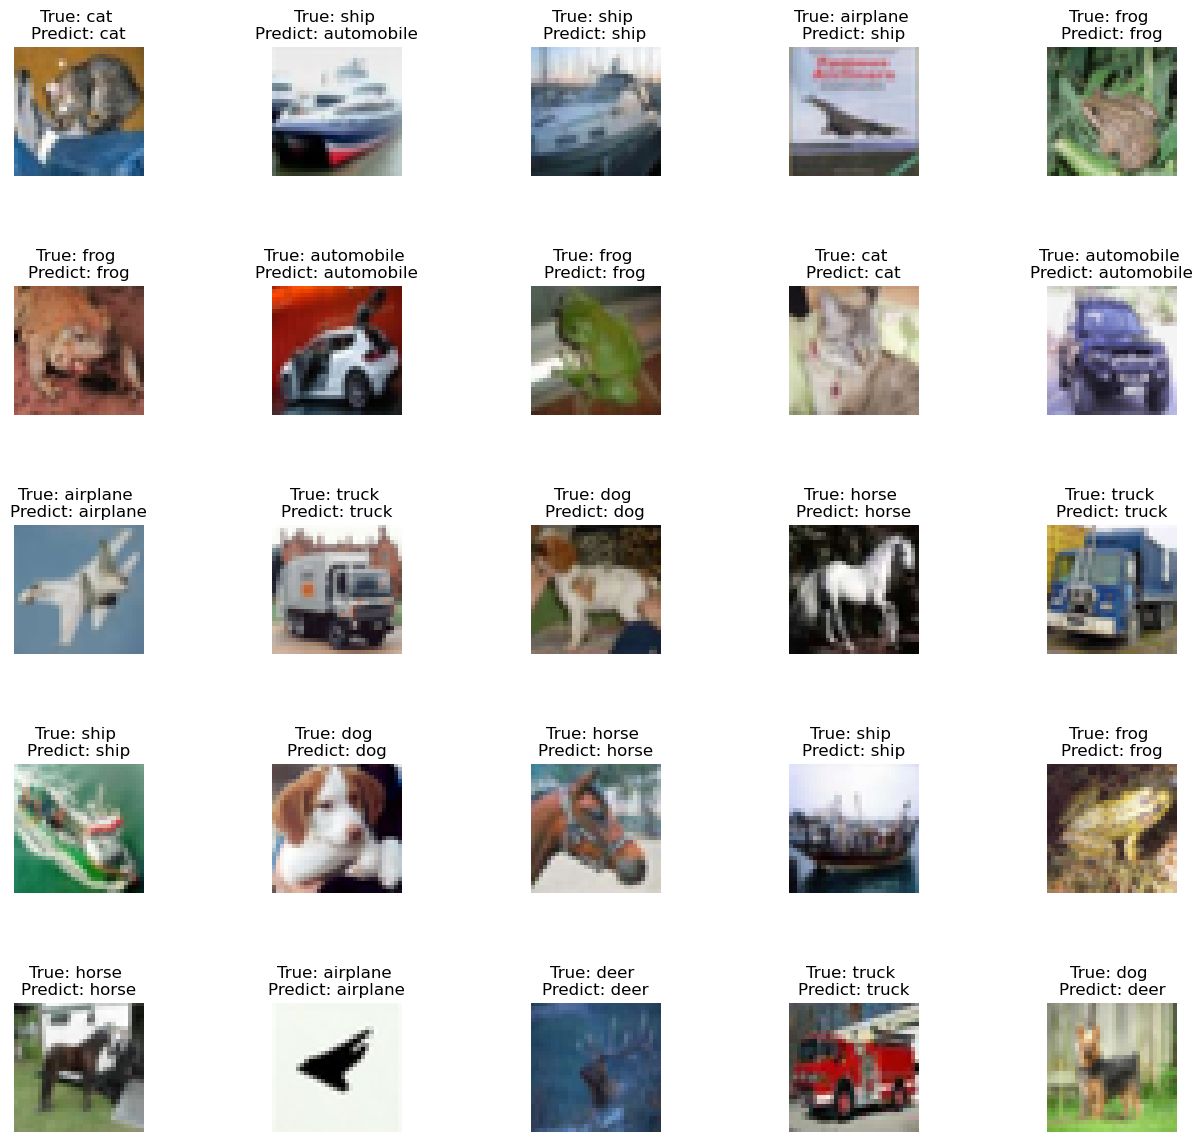

In [52]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(y_test[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
    

#### Predicting a few more examples

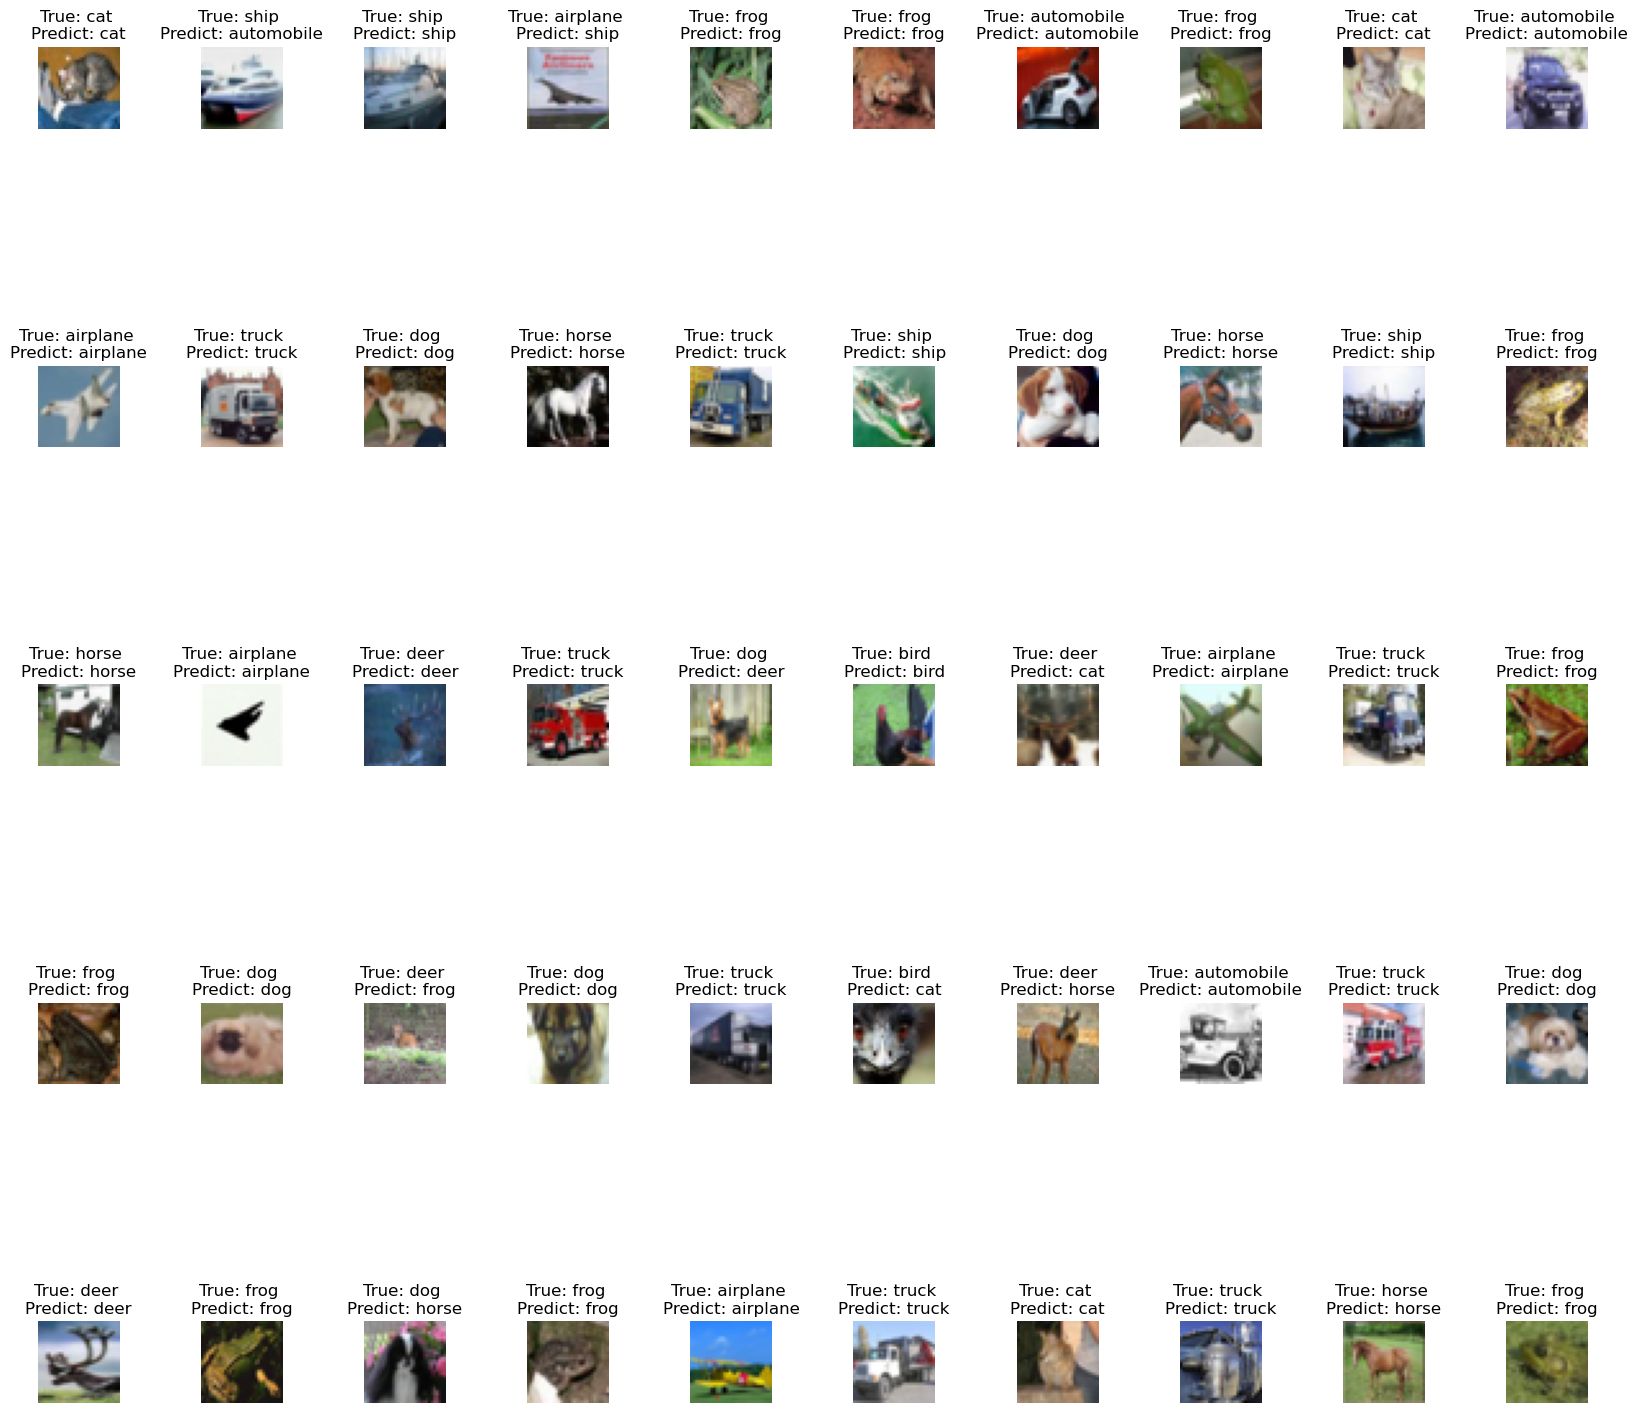

In [96]:
fig, axes = plt.subplots(5, 10, figsize=(20,20))
axes = axes.ravel()
for i in np.arange(0, 50):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(y_test[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
    

### Tuning Hyperparameters

In [102]:
# Create a folder path for Hyperparameter tuning
folder_path = "my_dir/intro_to_kt/"


#### Delete previous TensorBoard logs

In [103]:
import os
import shutil

# shutil module is part of the Python standard library and provides a 
# collection of utility functions for working with files and directories. 

folder_path = "logs/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")
    

The folder 'logs/' has been deleted.


In [104]:
# Delete the ".tensorboard-info" directory 

folder_path = "C:/Users/angel/AppData/Local/Temp/.tensorboard-info/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")
    

The folder 'C:/Users/angel/AppData/Local/Temp/.tensorboard-info/' does not exist.


<b>Hyperparameters Tuning </b>: 

 tune the neurons or units with values from 24 to 32 in multiple of 4

In [176]:
# Create a model-building function
def model_builder(hp):
    
    model = Sequential()
    model.add(Dense(units=hp.Int('dense_units_1', min_value=24, max_value=32, step=4),
                         activation='relu'))
    model.add(Dense(1, activation='softmax'))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model


Instantiate the tuner and perform hypertuning

In [177]:
tuner = RandomSearch( model_builder, objective='val_accuracy', max_trials=10,
    directory='my_dir', project_name='intro_to_kt')


Reloading Tuner from my_dir\intro_to_kt\tuner0.json


#### Create a variable stop_early for callbacks with EarlyStopping 


In [178]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


### Let's search for optimal values (tune hyperparameters) and display the result

In [179]:
# Search the hyperparameters to see which combination provides the best model result
tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10)



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |4                 |units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/10


Traceback (most recent call last):
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\L

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Aron\AppData\Local\Temp\__autograph_generated_filehfugj2_x.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 1024) are incompatible



In [168]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 12.



#### Build the final model using the optimal hyperparameters

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [181]:
# Create the final model with the optimal hyperparameters
final_model = tuner.hypermodel.build(best_hps)

In [182]:
# Fit model
history = final_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 1024) are incompatible


In [183]:
# Find the best epoch
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('The best epoch: %d' % (best_epoch,))

NameError: name 'history' is not defined

In [185]:
# Evaluate the model
eval_result = final_model.evaluate(x_train, y_train)
print("[test loss, test accuracy]:", eval_result)

ValueError: in user code:

    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1852, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Aron\anaconda3\Lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 10) and (None, 1024) are incompatible


### Confusion Matrix

In [187]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observation')
    plt.xlabel('Prediction')
    


313/313 [==============================] - 5s 17ms/step


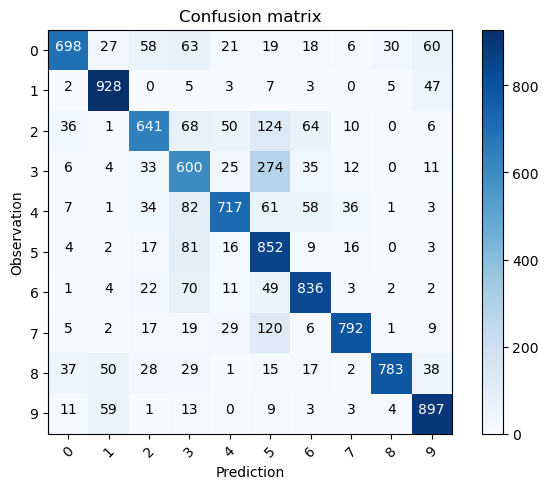

In [190]:

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


## Conclusion

The model trained through the CNN has a loss: 0.6211 - accuracy: 0.7868 - val_loss: 0.6804 - val_accuracy: 0.7744. The loss seems to go down sufficiently well and the accuracy is improved yet improved slowly after the later half of the epochs. So the trainig becomes more difficult and is not overfit. The predicted images are not perfect but accurate for the most part. The confusion matrix shows high prediction accuracy with a low of 698 in the top left and high of 897 at the bottom right.

#### Add a variable called  model.predict(X_valid)


In [192]:
predictions = model.predict(x_test)


313/313 [==============================] - 5s 16ms/step


The actual and predicted values are very close in the model generated.
